In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### 1. 그래프 상태 정의

In [87]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_nomic.embeddings import NomicEmbeddings
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict, List
from bs4 import BeautifulSoup
import requests
import uuid
import json
from IPython.display import Image, display
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain_community.vectorstores import SKLearnVectorStore

# Define the GraphState class
class GraphState(TypedDict):
    question: str
    documents: List[str]
    cleaned_text: str
    steps: List[str]

### 3. 노드 함수 정의

In [92]:
# 구글에서 문서를 검색하는 노드
def search_google(state):
    question = state["question"]
    search = GoogleSerperAPIWrapper(gl="kr", hl="ko", k=10)
    results = search.results(question)

    # Print the results for debugging
    #print("Search Results:", results)

    # Extract links from the 'organic' search results
    documents = [result["link"] for result in results.get("organic", [])]
    steps = state["steps"]
    steps.append("search_google")
    return {"documents": documents, "question": question, "steps": steps}


# 문서의 본문을 가져오는 노드
def fetch_documents(state):
    documents = state["documents"]
    fetched_docs = []
    for url in documents:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        paragraphs = soup.find_all("p")
        text = " ".join([p.get_text() for p in paragraphs])
        fetched_docs.append(text)
    steps = state["steps"]
    steps.append("fetch_documents")
    return {"documents": fetched_docs, "question": state["question"], "steps": steps}




# 문서를 정리하는 노드
def clean_documents(state):
    documents = state["documents"]
    combined_text = " ".join(documents)

    # 문장을 분리
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
    sentences = text_splitter.split_text(combined_text)

    # 문장 임베딩 생성
    nomic_embeddings = NomicEmbeddings(
        model="nomic-embed-text-v1.5", inference_mode="local"
    )

    # 유사한 문장 제거
    vector_store = SKLearnVectorStore.from_texts(
        texts=sentences,  # 분할된 텍스트 청크
        embedding=nomic_embeddings,  # Nomic 임베딩 모델 사용
    )

    unique_sentences = []
    seen_sentences = set()

    for sentence in sentences:
        # 중복 문장 여부를 확인하고 처리
        if sentence not in seen_sentences:
            similar_sentences = vector_store.similarity_search(sentence, k=1)
            is_unique = True
            for similar_sentence in similar_sentences:
                # Document 객체의 page_content 속성을 사용해 중복을 체크
                similar_content = similar_sentence.page_content.strip()
                if similar_content in seen_sentences:
                    is_unique = False
                    break
                seen_sentences.add(similar_content)

            if is_unique:
                unique_sentences.append(sentence)
                seen_sentences.add(sentence.strip())

    cleaned_text = " ".join(unique_sentences)
    steps = state["steps"]
    steps.append("clean_documents")
    return {"cleaned_text": cleaned_text, "question": state["question"], "steps": steps}


# 텍스트 파일로 저장하는 노드
def save_to_file(state):
    cleaned_text = state["cleaned_text"]
    with open("research_result.txt", "w", encoding="utf-8") as file:
        file.write(cleaned_text)
    steps = state["steps"]
    steps.append("save_to_file")
    return {"cleaned_text": cleaned_text, "question": state["question"], "steps": steps}

### 3. 그래프 정의 및 빌드

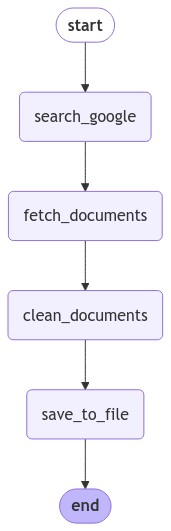

In [93]:
# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("search_google", search_google)  # Google search
workflow.add_node("fetch_documents", fetch_documents)  # Fetch documents
workflow.add_node("clean_documents", clean_documents)  # Clean documents
workflow.add_node("save_to_file", save_to_file)  # Save to file

# Build graph
workflow.add_edge(START, "search_google")
workflow.add_edge("search_google", "fetch_documents")
workflow.add_edge("fetch_documents", "clean_documents")
workflow.add_edge("clean_documents", "save_to_file")
workflow.add_edge("save_to_file", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

### 4. 에이전트 실행 함수 정의

In [ ]:
def predict_custom_agent_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )

    # Print the state dictionary for debugging
    #print("State Dictionary:", state_dict)

    return {"response": state_dict["cleaned_text"], "steps": state_dict["steps"]}


example = {"input": "갑자(甲子)"}
response = predict_custom_agent_answer(example)
print(response)